In [1]:
import torch
import torch.nn as nn
import os
from torch import optim
from model import VisionTransformer6
from utils_vit import get_loader
from tqdm import tqdm
import contextlib
import datetime
from torchvision.transforms import v2

In [2]:
device = torch.device("mps")

NUM_CLASSES = 10
train_loader, test_loader = get_loader()
model = VisionTransformer6().to(device)
ce = nn.CrossEntropyLoss()

cutmix = v2.CutMix(num_classes=NUM_CLASSES)
mixup = v2.MixUp(num_classes=NUM_CLASSES)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

def train_and_evaluate():
    optimizer = optim.AdamW(model.parameters(), 5e-4, weight_decay=1e-3)
    cos_decay = optim.lr_scheduler.CosineAnnealingLR(optimizer, 200, verbose=True)
    total_step = len(train_loader)

    accuracies = []

    for epoch in range(200):
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        model.train()
        for i, (images, labels) in pbar:
            with contextlib.redirect_stdout(open(os.devnull, "w")):
                optimizer.zero_grad()
                images, labels = cutmix_or_mixup(images.to(device), labels.to(device))
                outputs = model(images)
                loss = ce(outputs, labels)
                loss.backward()
                optimizer.step()
                if (i + 1) % 200 == 0:
                    pbar.set_description(f'Epoch [{epoch + 1}/{200}], Step [{i + 1}/{total_step}], Loss: {loss.item()}')
                cos_decay.step()

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            pbar_test = tqdm(test_loader)
            for images, labels in pbar_test:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                pbar_test.set_description(f'Accuracy: {100 * correct / total:.2f}%')

            accuracy = 100 * correct / total
            accuracies.append(accuracy)
    return accuracies

In [3]:
start_time = datetime.datetime.now()
accuracies = train_and_evaluate()
end_time = datetime.datetime.now()

best_accuracy = max(accuracies)
print(f'Final accuracy: {best_accuracy:.2f}%')
print(f'Training time: {end_time - start_time}')

Adjusting learning rate of group 0 to 5.0000e-04.


Epoch [1/200], Step [400/468], Loss: 1.4023854732513428: 100%|██████████| 468/468 [00:46<00:00, 10.13it/s]
Accuracy: 59.29%: 100%|██████████| 79/79 [00:04<00:00, 19.23it/s]
Epoch [2/200], Step [400/468], Loss: 0.9305771589279175: 100%|██████████| 468/468 [00:45<00:00, 10.35it/s]
Accuracy: 70.77%: 100%|██████████| 79/79 [00:04<00:00, 16.92it/s]
Epoch [3/200], Step [400/468], Loss: 1.713189959526062: 100%|██████████| 468/468 [00:46<00:00, 10.03it/s] 
Accuracy: 75.51%: 100%|██████████| 79/79 [00:05<00:00, 15.33it/s]
Epoch [4/200], Step [400/468], Loss: 1.6025195121765137: 100%|██████████| 468/468 [00:46<00:00, 10.05it/s]
Accuracy: 76.57%: 100%|██████████| 79/79 [00:04<00:00, 15.88it/s]
Epoch [5/200], Step [400/468], Loss: 1.6998425722122192: 100%|██████████| 468/468 [00:49<00:00,  9.36it/s]
Accuracy: 76.90%: 100%|██████████| 79/79 [00:05<00:00, 14.34it/s]
Epoch [6/200], Step [400/468], Loss: 1.5050175189971924: 100%|██████████| 468/468 [00:48<00:00,  9.73it/s]
Accuracy: 75.74%: 100%|█████

Final accuracy: 92.32%
Training time: 3:12:11.459586


[59.29, 70.77, 75.51, 76.57, 76.9, 75.74, 77.9, 80.48, 80.93, 81.47, 81.0, 81.25, 81.95, 82.98, 84.07, 84.08, 82.37, 83.87, 84.0, 85.28, 85.8, 85.91, 83.96, 85.27, 85.74, 86.48, 86.86, 86.19, 85.16, 86.08, 85.85, 87.45, 87.43, 87.07, 86.47, 86.68, 87.66, 87.88, 88.57, 87.72, 87.02, 87.57, 88.2, 88.74, 88.82, 88.1, 87.48, 87.96, 88.59, 88.79, 89.12, 88.0, 88.45, 88.74, 88.96, 89.2, 89.54, 88.79, 88.21, 88.73, 89.38, 89.63, 89.5, 88.46, 88.63, 88.78, 89.43, 89.93, 89.54, 88.49, 88.94, 89.0, 90.02, 89.99, 90.09, 89.58, 89.21, 89.22, 90.03, 90.44, 90.11, 89.42, 89.06, 90.03, 90.23, 90.45, 89.93, 89.91, 89.63, 90.09, 90.7, 90.52, 90.01, 89.62, 90.05, 90.32, 90.43, 90.11, 89.87, 90.09, 89.87, 90.6, 90.76, 90.33, 90.26, 89.95, 89.96, 90.72, 90.93, 90.76, 90.58, 89.9, 89.82, 90.74, 91.14, 91.15, 90.51, 90.59, 90.58, 90.92, 90.95, 91.19, 90.66, 90.34, 90.84, 91.36, 91.2, 91.19, 90.49, 90.62, 91.0, 91.16, 91.45, 91.26, 90.84, 90.61, 91.02, 91.54, 91.54, 91.55, 90.73, 90.62, 91.46, 91.57, 91.37, 

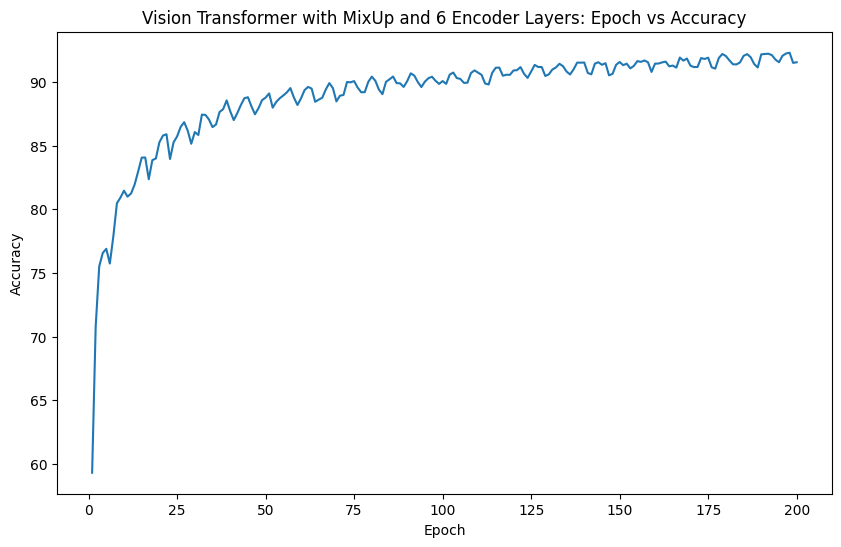

In [4]:
from matplotlib import pyplot as plt

print(accuracies)
epochs = list(range(1, len(accuracies) + 1))
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracies, linestyle='-')
plt.title('Vision Transformer with MixUp and 6 Encoder Layers: Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()